Filter Control Register:  0x13
Power Control Register:  0x2
Raw X, Y, Z Axis Data:  -39 -249 1075
ADXL362 Internal Temperature:  24.51 C


<IPython.core.display.Javascript object>


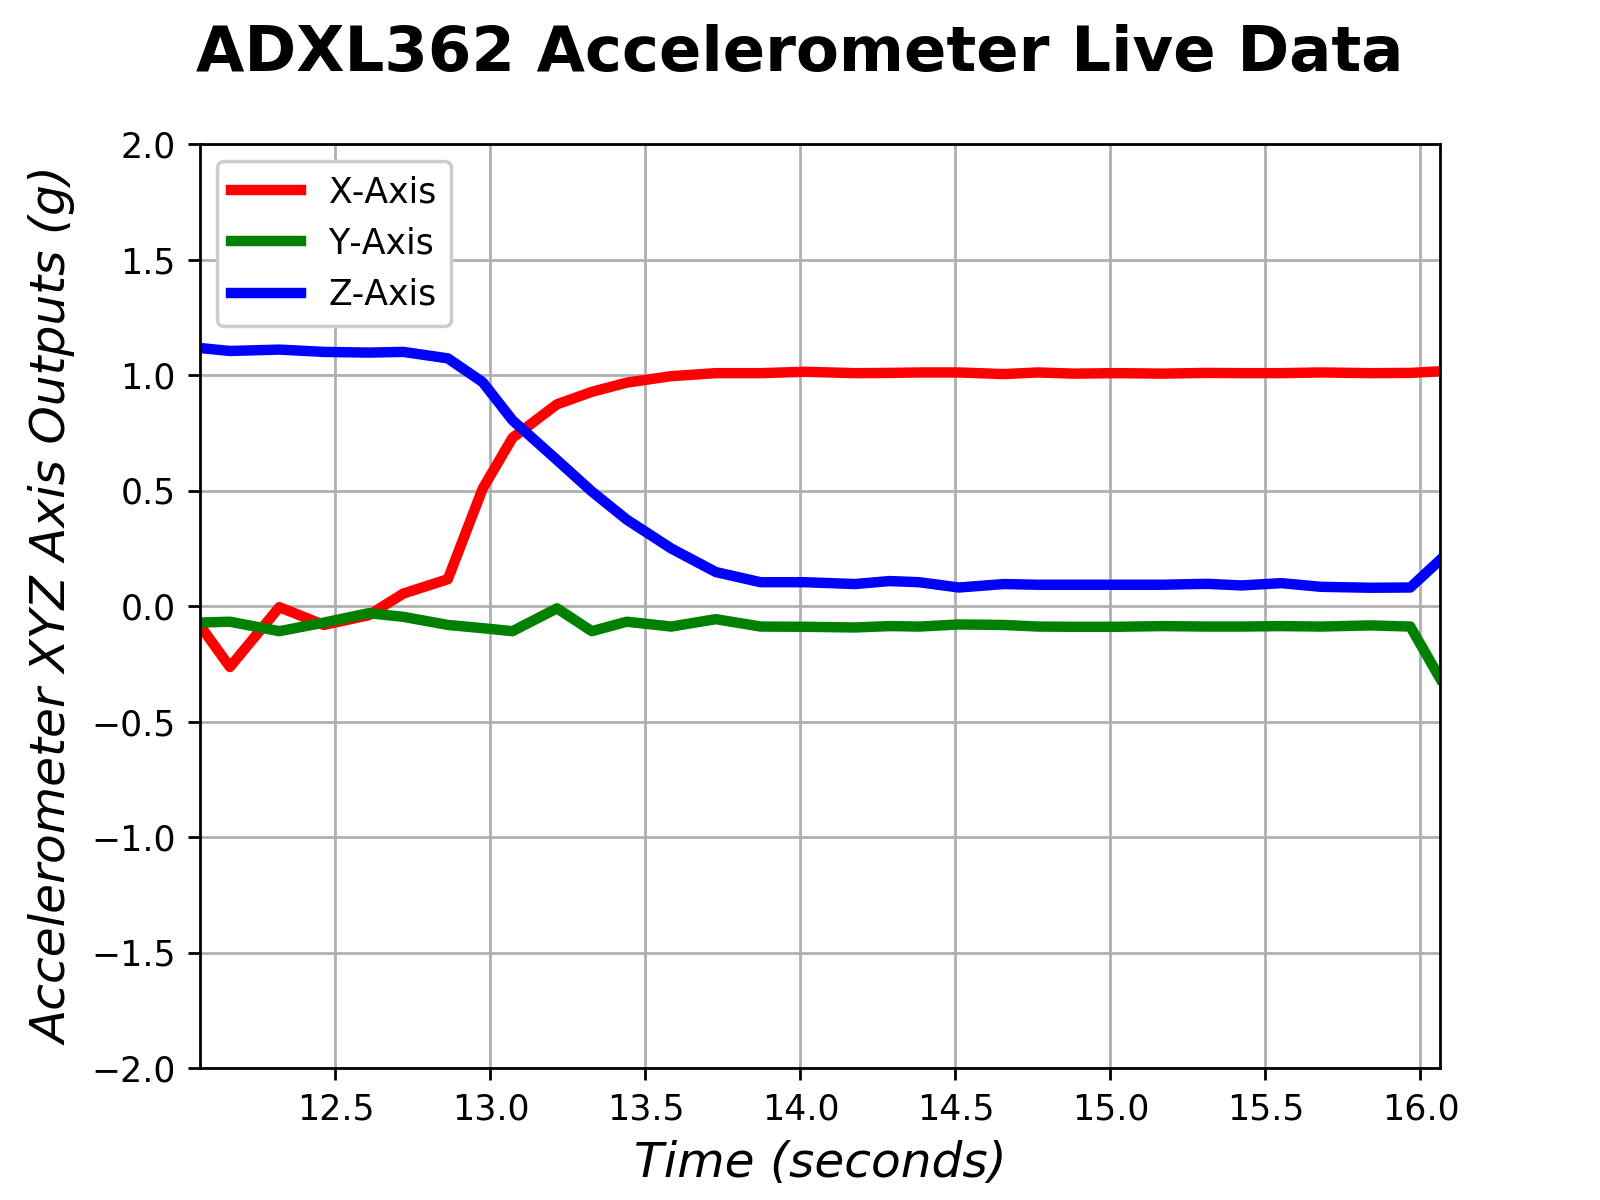

<IPython.core.display.Javascript object>


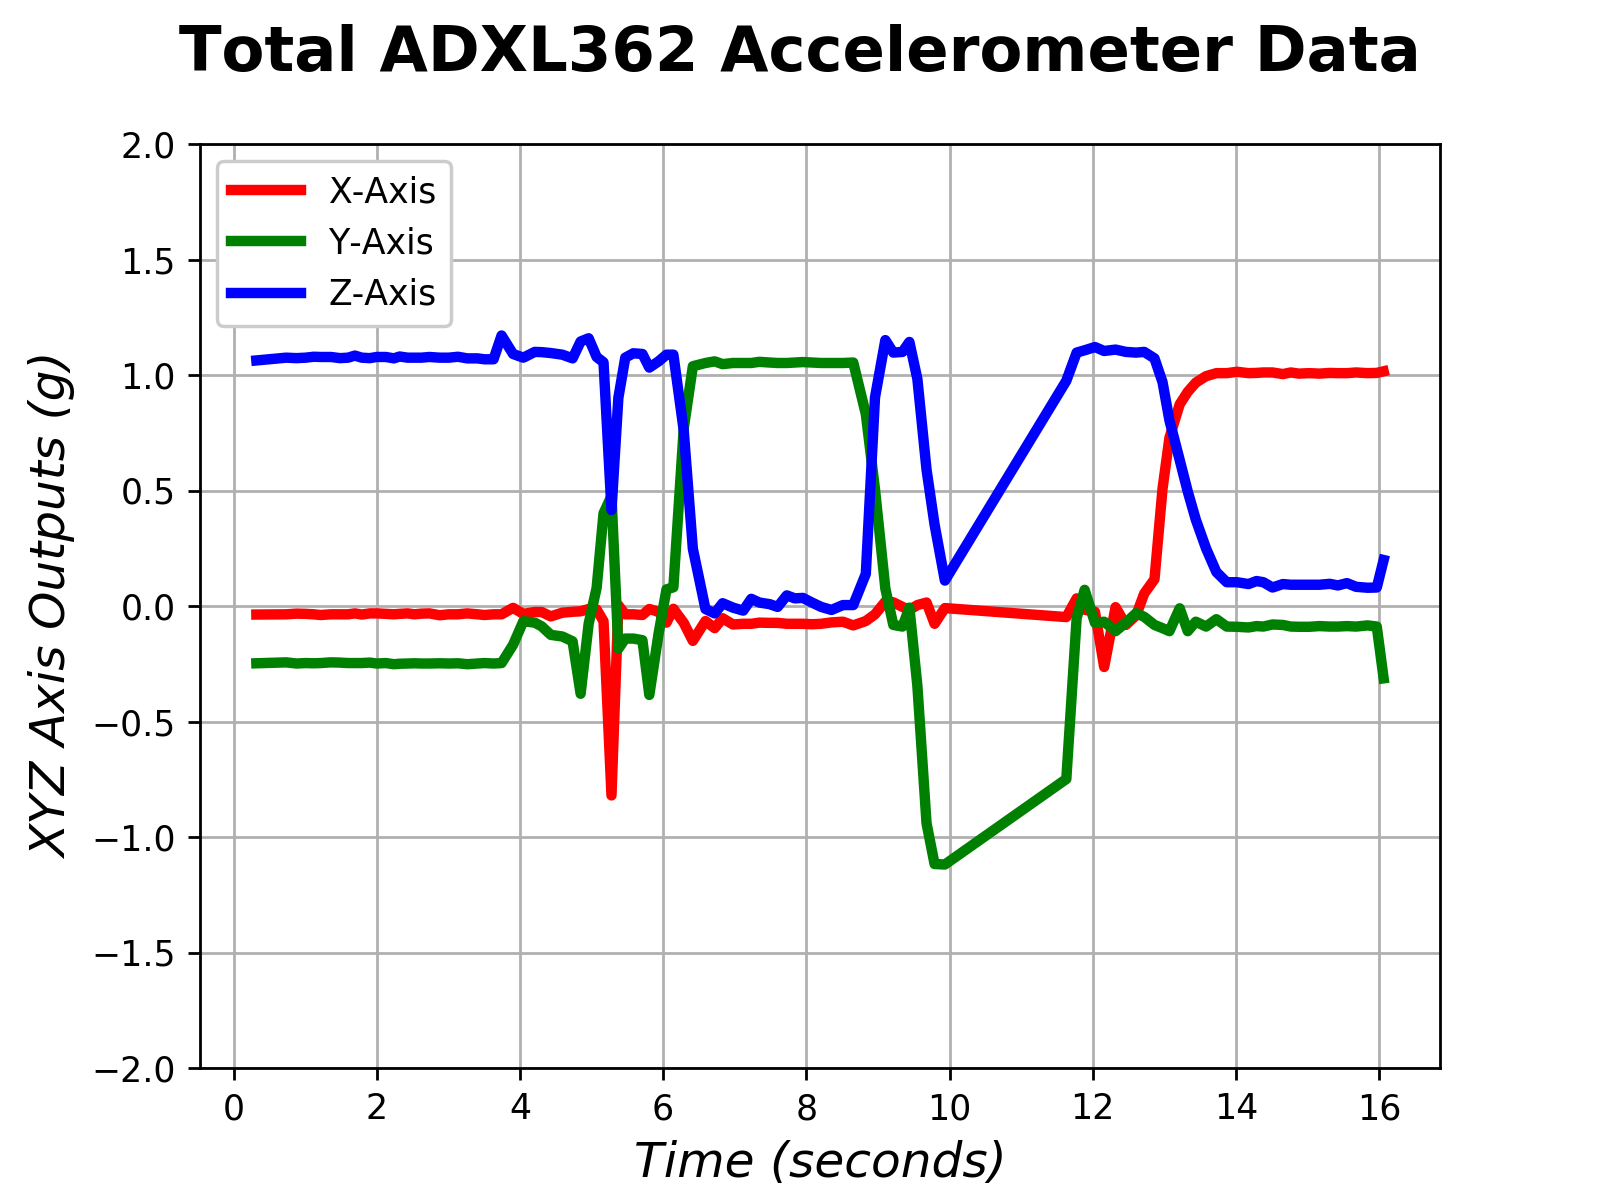

In [1]:
#
# 3- Axis Accelerometer Demo (Plot X,Y,Z)
#
%matplotlib notebook

import serial
import numpy as np
from matplotlib import pyplot as plt
from time import time

#
# Please change here to proper COM port name
#
ser = serial.Serial('COM11', 115200)
#
# ADXL362 register access functions
#
def ADXL362_write_reg(reg, value):
    cmd = "<0a%0.2x%0.2x>" % (reg, value) # Write command 0x0A
    ser.write(bytearray(cmd,'utf8'))  # Send command, REG and value
#
def ADXL362_read_reg8(reg):
    ser.reset_input_buffer()
    cmd = "<0b%0.2x..>" % reg # Read command 0x0B
    ser.write(bytearray(cmd,'utf8'))  # Send command, REG and value
    s = ser.read(2)
    return int(s,16)                  # Convert hex to int
#
def ADXL362_read_reg16(reg):
    ser.reset_input_buffer()
    cmd = "<0b%0.2x..><0b%0.2x..>" % (reg+1, reg) # Read command 0x0B
    ser.write(bytearray(cmd,'utf8'))  # Send command, REG and value
    s = ser.read(4)
    return int(s,16)                 # Convert hex to int
#
# Read sign extended 16 bit register 
#
def ADXL362_read_reg16_sx(reg):
    t = ADXL362_read_reg16(reg)
    if t > 32768: t = t - 65536
    return t    
#    
def ADXL362_read_axis(axis):
    return ADXL362_read_reg16_sx(axis*2 + 0x0e)
#
# reading sign extended temperature register and artifically offsetting bias with data sheet value (350)
def ADXL362_read_temperature():
    t = ADXL362_read_reg16_sx(0x14)
    return round(((t-350)*0.065), 2) # rounding value after offsetting by avg bias, and adjusting to resolution

ser.write(b'[0]')                # Select UHSA Channel 0 

# enable measurement mode only for ADXL362 
ADXL362_write_reg(0x2d,0x02)     

# diagnostics
# filter control register read
fcr = ADXL362_read_reg8(0x2C)
print("Filter Control Register: ", hex(fcr))

# power control register read
pcr = ADXL362_read_reg8(0x2D)
print("Power Control Register: ", hex(pcr))

# raw X,Y,Z axis data reads (1mg/LSB)
x_axis = ADXL362_read_axis(0)
y_axis = ADXL362_read_axis(1)
z_axis = ADXL362_read_axis(2)
print("Raw X, Y, Z Axis Data: ", x_axis, y_axis, z_axis)

# internal temperature read
temp = ADXL362_read_temperature()
print("ADXL362 Internal Temperature: ", temp, "C")

#
# Plot functions start here
#
plt.ion() 
start_time = time()
timepoints = []
xdata = []
ydata = []
zdata = []

yrange = [-2.0, 2.0] # default range is +/- 2g
view_time = 4 # seconds of data to view at once
duration = 16 # total seconds to collect data

# rolling view_time plot window
fig1 = plt.figure()
fig1.suptitle('ADXL362 Accelerometer Live Data', fontsize='18', fontweight='bold')
plt.axes().grid(True)
plt.xlabel('Time (seconds)', fontsize='14', fontstyle='italic')
plt.ylabel('Accelerometer XYZ Axis Outputs (g)', fontsize='14', fontstyle='italic')

# data plot
line1, = plt.plot(timepoints, xdata, color="red", linewidth=3.0)  
line2, = plt.plot(timepoints, ydata, color="green", linewidth=3.0) 
line3, = plt.plot(timepoints, zdata, color="blue", linewidth=3.0) 

# legend view
plt.legend((line1, line2, line3),          
           ('X-Axis', 'Y-Axis', 'Z-Axis'), 
           loc='upper left',
           framealpha=1.0)

# set the y plot axis range and show the plot
plt.ylim(yrange)
plt.xlim([0,view_time])

ser.flushInput() # flushing the serial input buffer
ser.reset_input_buffer() # reset the serial input buffer

# set the run boolean to 'true' to plot and collect data
run = True

# collect the data and plot a moving frame using view_time window size
while run:
    # 
    try:
        # reading all three accelerometer axes
        x = ADXL362_read_axis(0)    
        y = ADXL362_read_axis(1)    
        z = ADXL362_read_axis(2)    
            
        # store the entire dataset for later
        xdata.append(float(x)*(0.001)) # 0.001g/LSB scaling of raw value according to datasheet
        ydata.append(float(y)*(0.001))
        zdata.append(float(z)*(0.001))
        
        # updating timepoints array for x axis plot
        timepoints.append(time()-start_time)
        current_time = timepoints[-1]
        
        # update the plotted axes data
        line1.set_xdata(timepoints)
        line1.set_ydata(xdata)

        line2.set_xdata(timepoints)
        line2.set_ydata(ydata)

        line3.set_xdata(timepoints)
        line3.set_ydata(zdata)
        
        # slide the viewing frame along
        if current_time > view_time:
            plt.xlim([current_time-view_time,current_time])
            
        # when time's up, kill the collect+plot loop
        if timepoints[-1] > duration: run=False
    
    # if the try statement throws an error, just do nothing
    except: pass
    
    # update the plot
    fig1.canvas.draw()

# plot of the total data collected
fig2 = plt.figure()
fig2.suptitle('Total ADXL362 Accelerometer Data', fontsize='18', fontweight='bold')
plt.axes().grid(True)
plt.xlabel('Time (seconds)', fontsize='14', fontstyle='italic')
plt.ylabel('XYZ Axis Outputs (g)', fontsize='14', fontstyle='italic')

# data plot
plt.plot(timepoints, xdata, color="red", linewidth=3.0)
plt.plot(timepoints, ydata, color="green", linewidth=3.0)
plt.plot(timepoints, zdata, color="blue", linewidth=3.0)

# legend view
plt.legend((line1, line2, line3), 
           ('X-Axis', 'Y-Axis', 'Z-Axis'), 
           loc='upper left',
           framealpha=1.0)

# set the y plot axis range and show the plot
plt.ylim(yrange)
fig2.show()

# close the serial port after completion
ser.close()
